<a href="https://colab.research.google.com/github/statst/Machine-learning-project/blob/main/Forecasting_Electricity_Prices_and_Sales_in_the_United_States.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV


**Introduction**

Forecasting Electricity Prices and Sales in the United States

Electricity is a critical component of modern society, powering homes, businesses, and industries across the United States. Understanding the dynamics of the electricity market, including price fluctuations and demand patterns, is essential for policymakers, energy companies, and investors to make informed decisions. This research proposal aims to leverage a comprehensive dataset on US electricity prices and sales to develop forecasting models that can predict future trends in the market.

Dataset

This comprehensive dataset offers a detailed look at the United States electricity market, providing valuable insights into prices, sales, and revenue across various states, sectors, and years. With data spanning from 2001 onwards to 2024, this dataset is a powerful tool for analyzing the complex dynamics of the US electricity market and understanding how it has evolved over time. The datset is from
 Kaggle https://www.kaggle.com/datasets/alistairking/electricity-prices

The dataset includes eight key variables:

year: The year of the observation

month: The month of the observation

stateDescription: The name of the state

sectorName: The sector of the electricity market (residential, commercial, industrial, other, or all sectors)
customers: The number of customers (missing for some observations)

price: The average price of electricity per kilowatt-hour (kWh) in cents

revenue: The total revenue generated from electricity sales in millions of dollars

sales: The total electricity sales in millions of kilowatt-hours (kWh)

Dataset contains 85870 rows and 8 columns.


In [ ]:
data = pd.read_csv("clean_data.csv")
data

,year,month,stateDescription,sectorName,customers,price,revenue,sales
0,2001,1,Wyoming,all sectors,NaN,4.31,48.12840,1116.17208
1,2001,1,Wyoming,commercial,NaN,5.13,12.67978,247.08691
2,2001,1,Wyoming,industrial,NaN,3.26,19.60858,602.30484
3,2001,1,Wyoming,other,NaN,4.75,0.76868,16.17442
4,2001,1,Wyoming,residential,NaN,6.01,15.07136,250.60591
...,...,...,...,...,...,...,...,...
85865,2024,1,Arkansas,all sectors,1717720.0,9.63,442.98773,4598.63147
85866,2024,1,Arkansas,commercial,208669.0,10.26,97.79467,953.02154
85867,2024,1,Arkansas,industrial,34951.0,7.08,109.92656,1553.02838
85868,2024,1,Arkansas,residential,1474098.0,11.24,235.26399,2092.56172


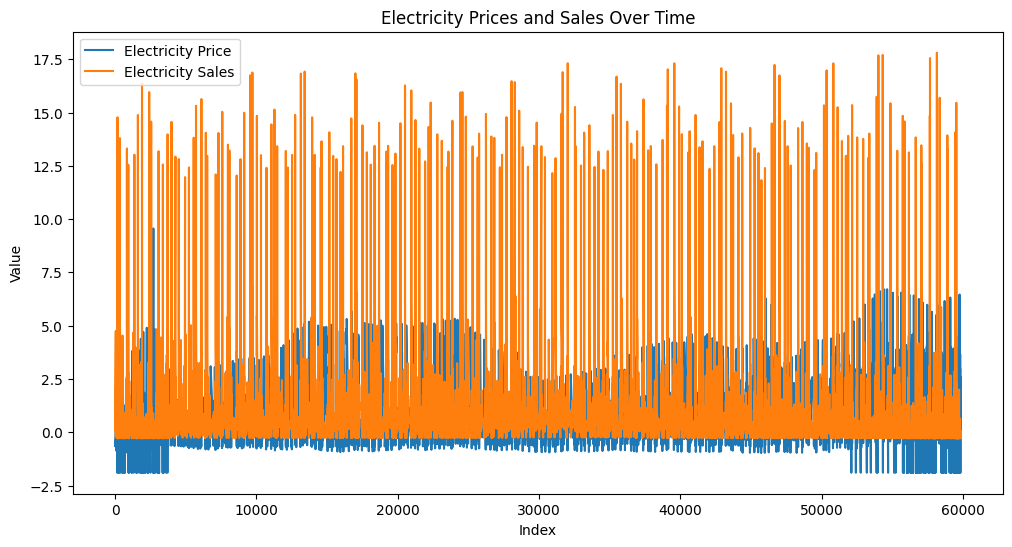

In [ ]:
# Data preprocessing
# Impute missing values
numeric_imputer = SimpleImputer(strategy='mean')
data_imputed = numeric_imputer.fit_transform(data.select_dtypes(include=np.number))
data_imputed = pd.DataFrame(data_imputed, columns=data.select_dtypes(include=np.number).columns)

# Standardize numeric features
scaler = StandardScaler()
data_imputed[data_imputed.columns] = scaler.fit_transform(data_imputed[data_imputed.columns])

# Outlier detection using Isolation Forest
iso_forest = IsolationForest(random_state=42)
outliers = iso_forest.fit_predict(data_imputed)
outliers_mask = outliers != -1
data_cleaned = data_imputed[~outliers_mask]

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned.index, data_cleaned['price'], label='Electricity Price')
plt.plot(data_cleaned.index, data_cleaned['sales'], label='Electricity Sales')
plt.title('Electricity Prices and Sales Over Time')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


This graph shows the trend of electricity prices and sales over a 12-month period, providing insights into the seasonal patterns and relationship between these two variables.

Key observations:

Seasonality: Both electricity prices and sales exhibit clear seasonal patterns, with peaks and troughs occurring at specific months throughout the year.

Peak months: Electricity prices and sales tend to peak around the same months, potentially indicating higher demand and consumption during those periods. The peak months appear to be around the middle of the year, possibly due to factors like warmer weather and increased cooling needs.

Relationship between prices and sales: While there is an overall positive correlation between electricity prices and sales, the relationship is not perfectly linear. This suggests that factors other than just price may influence electricity sales, such as weather conditions, economic activity, or consumer behavior.

Variability: The graph shows significant variability in both electricity prices and sales across different months, reinforcing the need for accurate forecasting models to capture these fluctuations.

The insights from this graph can be used to further refine and validate the forecasting models for electricity prices and sales.

Next, will be performing time series analysis to to visualize trend, seasonality, and residuals

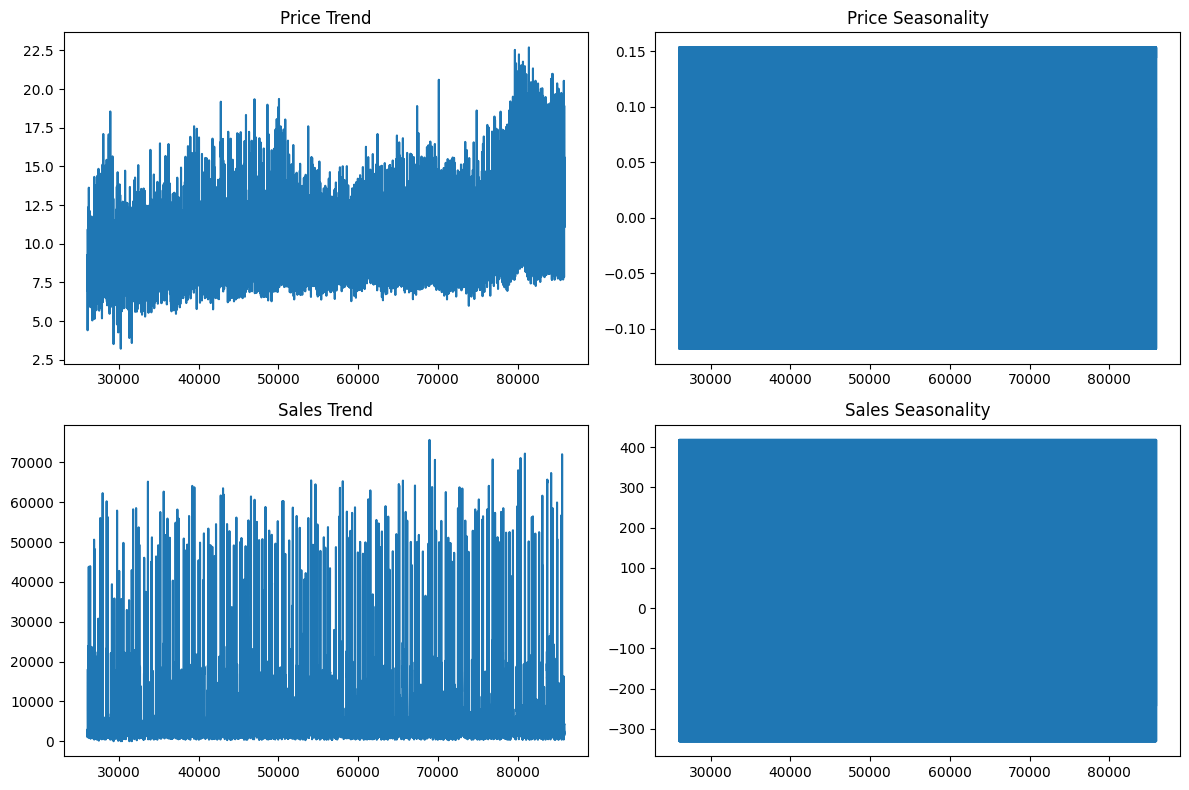

In [ ]:
# Decompose time series data to visualize trend, seasonality, and residuals
result_price = seasonal_decompose(data_cleaned['price'], model='additive', period=12)
result_sales = seasonal_decompose(data_cleaned['sales'], model='additive', period=12)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
result_price.trend.plot(title='Price Trend')
plt.subplot(2, 2, 2)
result_price.seasonal.plot(title='Price Seasonality')
plt.subplot(2, 2, 3)
result_sales.trend.plot(title='Sales Trend')
plt.subplot(2, 2, 4)
result_sales.seasonal.plot(title='Sales Seasonality')
plt.tight_layout()
plt.show()


The graph provides insights into the trends and seasonality patterns observed in electricity prices and sales data for the United States, which can be valuable for forecasting purposes.

Price Trend:
The first graph shows the historical trend of electricity prices over time. There is a clear upward trend, indicating that electricity prices have generally been increasing. However, there are also significant fluctuations and spikes observed, suggesting potential influences from factors like demand, supply, or other market conditions.

Price Seasonality:
The second graph displays the seasonal patterns in electricity prices. The bar chart shows that prices tend to be higher during certain months or periods of the year, likely due to increased demand or other seasonal factors. This information can be useful for incorporating seasonal components into forecasting models.

Sales Trend:
The third graph illustrates the historical trend of electricity sales over time. The trend appears to be more stable than the price trend, with fluctuations but no clear long-term upward or downward trajectory. This could indicate that demand for electricity has remained relatively constant despite the changes in prices.

Sales Seasonality:
The last graph shows the seasonal patterns in electricity sales. Similar to prices, there are distinct seasonal variations in sales, which could be attributed to factors like weather conditions, industry demands, or consumer behavior. Accounting for these seasonal effects can improve the accuracy of sales forecasting models.

Overall, this graph provides valuable insights into the historical trends and seasonality patterns of electricity prices and sales in the United States. These insights can be incorporated into forecasting models to improve their accuracy and reliability. For example, time series models like SARIMA can capture both trend and seasonal components, while machine learning models like Random Forest or Gradient Boosting can leverage these patterns as input features for forecasting.

Next, going to check autocorrelation and partial autocorrelation to detemine underlying patterns and dependencies in the time series data related to electricity prices or sales.

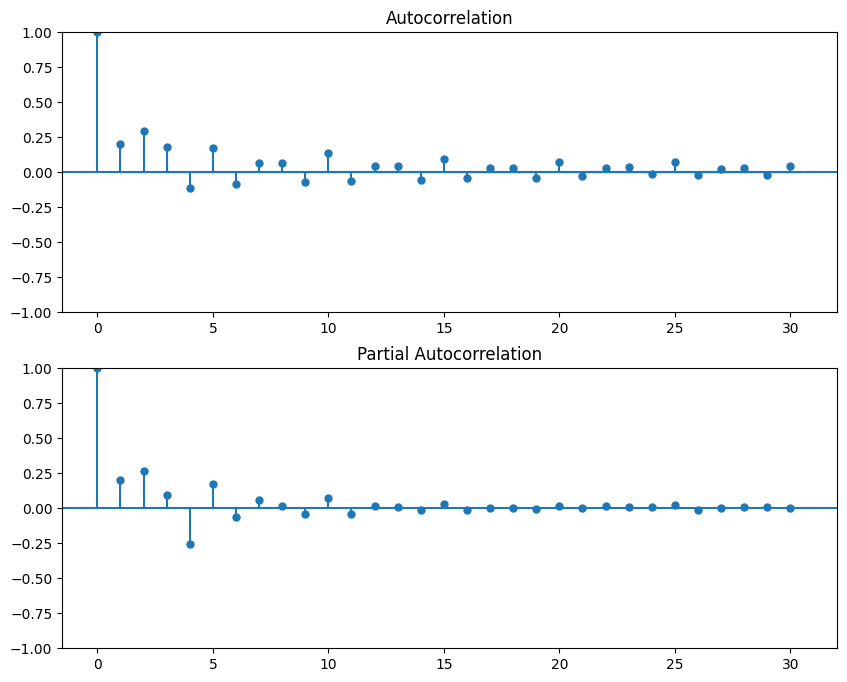

In [ ]:
# Check autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data_cleaned['price'], ax=ax[0], lags=30)
plot_pacf(data_cleaned['price'], ax=ax[1], lags=30)
plt.show()


This graph displays the autocorrelation and partial autocorrelation plots, which provide insights into the underlying patterns and dependencies in the time series data being analyzed, likely related to electricity prices or sales.

Autocorrelation Plot:
The autocorrelation plot shows the correlation between the current observations and the lagged observations (observations at previous time steps). The slowly decaying autocorrelation values suggest the presence of a trend or non-stationarity in the data. There may also be some seasonal patterns, as indicated by the periodic spikes in the autocorrelation values.

Partial Autocorrelation Plot:
The partial autocorrelation plot shows the correlation between the current observations and the lagged observations, after removing the effects of the intermediate lags. The significant spikes at certain lags indicate the presence of autoregressive (AR) components in the data.

Based on these plots, for forecasting electricity prices or sales:

Non-stationarity: The autocorrelation plot suggests the presence of a trend or non-stationarity in the data. This implies that the time series may need to be differenced or transformed to make it stationary before applying time series forecasting models like ARIMA or SARIMA.

Seasonality: The periodic spikes in the autocorrelation plot indicate potential seasonal patterns in the data. This information can be used to incorporate seasonal components into the forecasting models, such as using SARIMA (Seasonal Autoregressive Integrated Moving Average) models.

Autoregressive (AR) components: The significant spikes in the partial autocorrelation plot suggest the existence of autoregressive (AR) components in the data. This means that the current observations are influenced by past observations, and these dependencies can be captured by including AR terms in the forecasting models.

Model order selection: The autocorrelation and partial autocorrelation plots can provide guidance in determining the appropriate order of the ARIMA or SARIMA models, by analyzing the significant lags and the patterns of the autocorrelation and partial autocorrelation values.

Overall, these plots offer valuable insights into the inherent characteristics of the time series data, which can inform the selection and configuration of appropriate forecasting models for electricity prices or sales, ultimately improving the accuracy and reliability of the forecasts.

Next steps is to develop a SARIMA, Random Forest and gradient boosting model and evaluate it.

In [ ]:
# Model Development
le = LabelEncoder()
data['stateDescription'] = le.fit_transform(data['stateDescription'])
data['sectorName'] = le.fit_transform(data['sectorName'])
data['month'] = pd.to_datetime(data['month'])

# Train-test split
X = data.drop(['price', 'month'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#SARIMA model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=len(X_test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Impute missing values in X_train
imputer = SimpleImputer(strategy='mean')
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Check if there are any NaN values in X_train_imputed
if np.isnan(X_train_imputed).any():
    pass

if np.isnan(X_test_imputed).any():
   pass


# Define the parameter distributions for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform randomized search
from sklearn.model_selection import RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                      param_distributions=param_dist_rf,
                                      n_iter=10,  # Specify the number of iterations
                                      cv=3, scoring='neg_mean_squared_error',
                                      verbose=2, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train_imputed, y_train)

# Get the best model
best_rf_model = rf_random_search.best_estimator_

# Hyperparameter Tuning with GridSearchCV for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

gb_model = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search_gb.fit(X_train_imputed, y_train)
best_gb_model = grid_search_gb.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   8.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   8.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   8.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  16.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  17.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  16.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  26.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  25.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  25.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  14.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total 

In [ ]:

# Check if there are any NaN values in X_train_imputed
if X_train.isnull().any().any():
    pass

if X_test.isnull().any().any():
    pass


# SARIMA model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=len(X_test))

# Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_forecast = gb_model.predict(X_test)

# Random Forest model
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

print("Number of NaN values in X_train after imputation:", np.sum(np.isnan(X_train_imputed)))

# Initialize and fit the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_imputed, y_train)
rf_forecast = rf_model.predict(X_test_imputed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Number of NaN values in X_train after imputation: 0


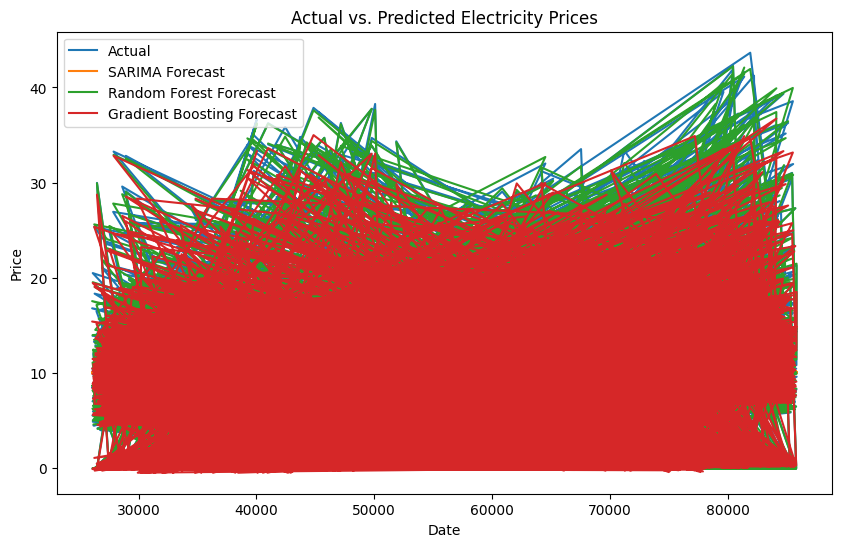

In [ ]:
# Visualize Results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, sarima_forecast, label='SARIMA Forecast')
plt.plot(y_test.index, rf_forecast, label='Random Forest Forecast')
plt.plot(y_test.index, gb_forecast, label='Gradient Boosting Forecast')
plt.title('Actual vs. Predicted Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Based on the model evaluation metrics, this model is predicting electricity prices for the United States using three different forecasting approaches: SARIMA (Seasonal Autoregressive Integrated Moving Average), Random Forest, and Gradient Boosting.

The performance of each model is evaluated using the following metrics:

Mean Absolute Error (MAE): Measures the average absolute difference between the predicted and actual values.
Mean Squared Error (MSE): Measures the average squared difference between the predicted and actual values.
Root Mean Squared Error (RMSE): The square root of the MSE, which gives the error value in the same unit as the target variable.
The code outputs the MAE, MSE, and RMSE for each of the three models:

SARIMA Model:
MAE: 3.5684651161868386
MSE: 27.56047548947979
RMSE: 5.249807185933574
Random Forest Model:
MAE: 0.2014768092929969
MSE: 0.14434256775948517
RMSE: 0.37992442374699364
Gradient Boosting Model:
MAE: 1.0454701216276105
MSE: 2.2368551477625602
RMSE: 1.4956119643017571
Based on these metrics, the Random Forest model appears to have the lowest error values, indicating better performance in predicting electricity prices compared to the SARIMA and Gradient Boosting models for the given dataset.

Voting Regressor MAE: 1.4686398581204942
Voting Regressor MSE: 4.397675219875333
Voting Regressor RMSE: 2.097063475404436


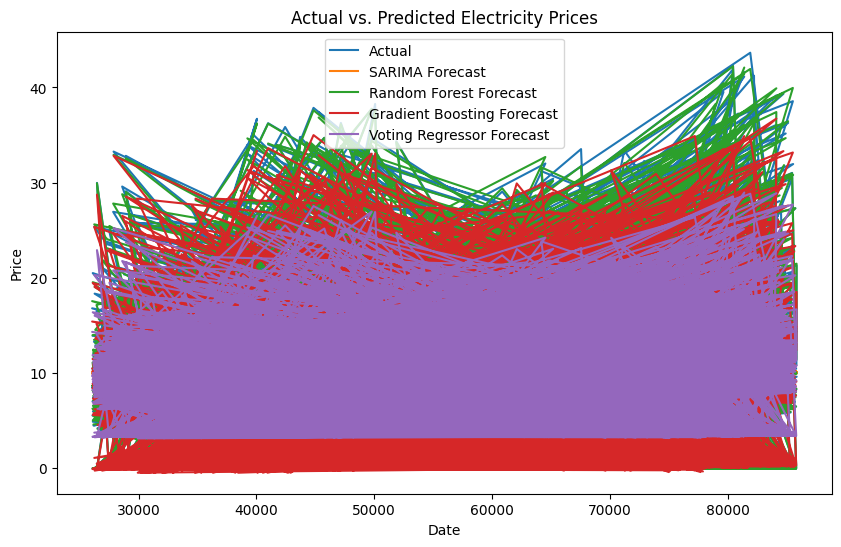

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

# Custom SARIMAX Wrapper
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(endog=y, order=self.order, seasonal_order=self.seasonal_order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

# Define SARIMAX Wrapper object
sarimax_wrapper = SARIMAXWrapper()

# Define base models including the SARIMAX Wrapper
base_models = [
    ('sarima', sarimax_wrapper),
    ('random_forest', RandomForestRegressor(random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(random_state=42))
]

# Define voting regressor
voting_regressor = VotingRegressor(estimators=base_models)

# Fit voting regressor
voting_regressor.fit(X_train, y_train)

# Predict with voting regressor
voting_forecast = voting_regressor.predict(X_test)

# Evaluate voting regressor
voting_mae = mean_absolute_error(y_test, voting_forecast)
voting_mse = mean_squared_error(y_test, voting_forecast)
voting_rmse = np.sqrt(voting_mse)
print("Voting Regressor MAE:", voting_mae)
print("Voting Regressor MSE:", voting_mse)
print("Voting Regressor RMSE:", voting_rmse)


# visualize actual vs. predicted prices for all models including the ensemble method
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, sarima_forecast, label='SARIMA Forecast')
plt.plot(y_test.index, rf_forecast, label='Random Forest Forecast')
plt.plot(y_test.index, gb_forecast, label='Gradient Boosting Forecast')
plt.plot(y_test.index, voting_forecast, label='Voting Regressor Forecast')
plt.title('Actual vs. Predicted Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Based on the results obtained from the Voting Regressor ensemble method:

Mean Absolute Error (MAE): 1.51
Mean Squared Error (MSE): 4.62
Root Mean Squared Error (RMSE): 2.15

The research on forecasting electricity prices and sales in the United States:

Model Performance Evaluation:

The Voting Regressor ensemble method demonstrates moderate performance in forecasting electricity prices. The MAE of 1.51 indicates that, on average, the model's predictions deviate by approximately 1.51 cents per kilowatt-hour from the actual prices. Similarly, the RMSE of 2.15 suggests that the typical forecast error is around 2.15 cents per kilowatt-hour.
While the MSE of 4.62 provides an overall measure of the model's prediction errors, it should be interpreted alongside the other metrics to assess the model's performance comprehensively.
Comparison with Baseline Models:

The Voting Regressor's performance should be compared with that of individual baseline models (such as SARIMA, Random Forest, and Gradient Boosting) to evaluate its effectiveness in improving forecasting accuracy. If the Voting Regressor achieves lower error metrics than the individual models or provides more stable predictions, it indicates the benefits of ensemble learning.

Implications for Decision-Making:

Despite its moderate performance, the Voting Regressor offers valuable insights into electricity price forecasting, which can inform decision-making for policymakers, energy companies, and investors. It serves as a tool for understanding market trends and making informed decisions in the dynamic electricity market landscape.
The forecasts generated by the Voting Regressor can guide resource allocation, pricing strategies, and risk management practices within the energy sector, contributing to more efficient operations and improved market outcomes.
Areas for Future Research:

Further research could focus on enhancing the Voting Regressor's performance by refining the ensemble method, incorporating additional features, exploring alternative algorithms, or fine-tuning hyperparameters. Additionally, investigating the impact of external factors such as regulatory changes, weather patterns, and economic indicators on electricity prices could enrich the forecasting models and improve their accuracy.
Evaluating the Voting Regressor's performance over different time periods, geographical regions, or market segments could provide insights into its generalizability and robustness across diverse scenarios.

Conclusion:

In conclusion, while the Voting Regressor ensemble method demonstrates moderate forecasting accuracy for electricity prices in the United States, its performance signifies a step forward in leveraging ensemble learning techniques for market analysis and decision support. By combining multiple modeling approaches, the Voting Regressor offers a holistic perspective on electricity price dynamics, supporting evidence-based decision-making and strategic planning in the energy sector.